**Part 2**: Recommender System

# Import Libraries / Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input, Reshape, dot, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam#, SGD, RMSprop, Adadelta, Adamax, Adagrad
from tensorflow.keras.losses import mean_squared_error as mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import tensorflow_hub as hub

from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel, AutoConfig

import torch

from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

import visualkeras

pd.options.display.max_colwidth = 200

def set_seed(seed_value=42):
    '''Set seed for reproducibility'''
    
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

/Users/benjaminpoh/opt/anaconda3/envs/tensordsi24/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df_sweetmarias = pd.read_csv('../data/cleaned_sweetmarias.csv')

In [3]:
df_sweetmarias.fillna('', inplace=True)

# Brief Introduction

For Part 2, the aim is to leverage the text data from the OCR tool to generate recommendations of related coffees to buy from Sweet Marias. For example, if the OCR tool generates these words `['plum, berry, caturra, washed']`, we should ideally get recommendations on 5 coffees with very similar descriptions from Sweet Marias. The motivation for creating this OCR tool is to identify potential application in a real world setting. Recommending coffees to buy is just an avenue to commercialise this concept, and there are several possible areas to explore in the future (e.g. user reviews, social network).

There are a few different NLP/deep-learning methods that I will try out in this section. These are a **baseline TF-IDF model**, a **feed-forward neural network auto-encoder**, a **Word2Vec model** and a **BERT transformer**.

This will be a content-based recommender system and recommendations are ranked based on the cosine distance of the word vectors generated from the 'query' (OCR text) and each coffee description from Sweet Marias.

## Dataset

The dataset is pulled from Sweet Marias' website with the web-scraping notebook. It consists of 341 different coffee data scraped from SweetMarias in the 1st week of November 2021. The scraped data includes information such as country, region/farm, description of tasting notes, processing method and bean variety. For this project, I have chosen to combine *description*, *processing method* and *variety* as the 'document' for each coffee. Collectively, these 341 documents make up the corpus for this project. 

I have decided to exclude country and region/farm in the document because one of the intentions of the recommender system is to propose coffees based on the taste profile of the bean. For example, if the country 'Colombia' is part of the query sentence, having country names in each document will likely result in mostly Colombian coffees being the top 5 recommendations - while this might be perfect for someone looking for Colombian coffees, the intention of this recommender system is to prioritise tasting notes instead of country similarity.

# Pre-processing & EDA

## Pre-processing

In terms of pre-processing, there are a few basic text cleaning steps (lowercase text, removing \n etc.) followed by simple tokenization (with the option of lemmatization). Tokenization will not apply to the BERT model as it has its own in-built tokenization process in the architecture offered by SentenceTransformers.

In [4]:
#Stopwords to exclude

new_stop_words = ['coffee','bean','beans','roaster','roasters','process','variety']
total_stop_words = text.ENGLISH_STOP_WORDS.union(new_stop_words)

In [5]:
def clean_text(text):
    '''Function to apply basic cleaning'''
    
    text = text.lower() #lowercase all text
    text = re.sub(r'(\r\n|\r|\n)',' ',text) #remove \r and \n
    text = re.sub(r'[^\w\s]',' ',text) #remove all non-alphanumeric characters
    
    #Apply stopwords
    stopwords=total_stop_words
    text = [i for i in text.split() if i not in stopwords]
    text = ', '.join(text)
    return text

In [6]:
def tokenizer(document, stopwords=total_stop_words, lemmatize=True):
    '''Function to tokenize words with option to apply lemmatization'''
    
    doc = document.split(', ')
    doc = ' '.join(doc)
    
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        
        tokens = [lemmatizer.lemmatize(i) for i in word_tokenize(doc)]
    else:
        tokens = [i for i in word_tokenize(doc)]
    
    return tokens

In [7]:
df_sweetmarias['cleaned_combined'] = df_sweetmarias['exlc_name_combined'].apply(clean_text)

In [8]:
df_sweetmarias['tok_lem_combined'] = df_sweetmarias['cleaned_combined'].apply(lambda x: tokenizer(x, stopwords=total_stop_words, lemmatize=True))

In [9]:
df_sweetmarias.head(5)

,Name,URL,Description,Process,Variety,all_combined,exlc_name_combined,cleaned_combined,tok_lem_combined
0,Burundi Commune Mutambu,https://www.sweetmarias.com/burundi-commune-mutambu-6644.html,"Such a versatile Burundi, a neutral sweetness is accented by complex baking spices, creamed honey, loose leaf black tea and bittering cocoa when roasted dark. City to Full City+. Good for espresso.",Wet Washed,Bourbon,"Burundi Commune Mutambu, Such a versatile Burundi, a neutral sweetness is accented by complex baking spices, creamed honey, loose leaf black tea and bittering cocoa when roasted dark. City to Full...","Such a versatile Burundi, a neutral sweetness is accented by complex baking spices, creamed honey, loose leaf black tea and bittering cocoa when roasted dark. City to Full City+. Good for espresso...","versatile, burundi, neutral, sweetness, accented, complex, baking, spices, creamed, honey, loose, leaf, black, tea, bittering, cocoa, roasted, dark, city, city, good, espresso, wet, washed, bourbon","[versatile, burundi, neutral, sweetness, accented, complex, baking, spice, creamed, honey, loose, leaf, black, tea, bittering, cocoa, roasted, dark, city, city, good, espresso, wet, washed, bourbon]"
1,Burundi Dry Process Gaterama Agahore,https://www.sweetmarias.com/burundi-dry-process-gaterama-agahore-6751.html,"Unapologetic ""dry process"" flavor that should satisfy those longing for berry-toned naturals ala ""Harrar"". Blackberry reduction, maple syrup, rustic dried fruit and earthy accents. City+ to Full C...",Dry Natural,Bourbon,"Burundi Dry Process Gaterama Agahore, Unapologetic ""dry process"" flavor that should satisfy those longing for berry-toned naturals ala ""Harrar"". Blackberry reduction, maple syrup, rustic dried fru...","Unapologetic ""dry process"" flavor that should satisfy those longing for berry-toned naturals ala ""Harrar"". Blackberry reduction, maple syrup, rustic dried fruit and earthy accents. City+ to Full C...","unapologetic, dry, flavor, satisfy, longing, berry, toned, naturals, ala, harrar, blackberry, reduction, maple, syrup, rustic, dried, fruit, earthy, accents, city, city, dry, natural, bourbon","[unapologetic, dry, flavor, satisfy, longing, berry, toned, natural, ala, harrar, blackberry, reduction, maple, syrup, rustic, dried, fruit, earthy, accent, city, city, dry, natural, bourbon]"
2,Burundi Dry Process Kibingo,https://www.sweetmarias.com/burundi-dry-process-kibingo-6749.html,"Cooked fruit and wheat flavors that bring to mind raspberry pie, hints of barley malt syrup and dried prune. Soft acidity and bittersweet at Full City, a note of dark cacao bar with crisped rice. ...",Dry Natural,Bourbon,"Burundi Dry Process Kibingo, Cooked fruit and wheat flavors that bring to mind raspberry pie, hints of barley malt syrup and dried prune. Soft acidity and bittersweet at Full City, a note of dark ...","Cooked fruit and wheat flavors that bring to mind raspberry pie, hints of barley malt syrup and dried prune. Soft acidity and bittersweet at Full City, a note of dark cacao bar with crisped rice. ...","cooked, fruit, wheat, flavors, bring, mind, raspberry, pie, hints, barley, malt, syrup, dried, prune, soft, acidity, bittersweet, city, note, dark, cacao, bar, crisped, rice, city, city, dry, natu...","[cooked, fruit, wheat, flavor, bring, mind, raspberry, pie, hint, barley, malt, syrup, dried, prune, soft, acidity, bittersweet, city, note, dark, cacao, bar, crisped, rice, city, city, dry, natur..."
3,Burundi Honey Process Gahahe,https://www.sweetmarias.com/burundi-honey-process-gahahe-6747.html,"Sweet, clean cup character like wet process Burundi, burned sugar sweetness, bergamot orange aroma, old fashioned spice cookies, and an acidic impression like strong black tea. City to Full City. ...",Honey,Bourbon,"Burundi Honey Process Gahahe, Sweet, clean cup character like wet process Burundi, burned sugar sweetness, bergamot orange aroma, old fashioned spice cookies, and an acidic impression like strong ...","S

## EDA

**Average length of sentence**

In [15]:
doc_length = []
for document in range(len(df_sweetmarias['tok_lem_combined'])):
    doc_length.append(len(df_sweetmarias['tok_lem_combined'][document]))

avg_doc_length = sum(doc_length)/len(doc_length)
print(f'{round(avg_doc_length)}' + ' words')

27 words


**Most Common Words**

In [16]:
words = []
for document in range(len(df_sweetmarias['tok_lem_combined'])):
    for word in df_sweetmarias['tok_lem_combined'][document]:
        words.append(word)
        
words = pd.DataFrame(words)
words.value_counts().head(15)

city         724
wet          253
washed       248
note         230
bourbon      175
espresso     172
flavor       169
sweetness    167
good         165
sugar        162
roast        149
chocolate    136
hybrid       130
modern       128
hint         119
dtype: int64

# Query

This is an example query that we will run through for the four models.

In [17]:
query = 'plum, berry, caturra, washed'

# TF-IDF (Baseline)

Term Frequency Inverse Document Frequency (TF-IDF) is one of the easiest and fastest ways to analyse the relevance of a term (word) in a given document. It gives a numerical weightage of words (to reflect its importance in the document), and weighs down the frequently occurings words to identify the difference between one document and another. However, as a simple model, it does not understand semantics, synonyms or other nuances in language.

We will be using the TF-IDF as a baseline model to compare against the other more complex models. As much as it is a corpus exploration method, TF-IDF is also used as a pre-processing step for other models. Therefore, we will also be using the TF-IDF matrix as a pre-processed input for the auto-encoder model that I've built in the later section.

In [18]:
def recommend_coffee_from_description_tfidf(query, model_embed):
    '''Function to calculate cosine similarity and return top 5 recommendations'''
    
    #Embed query
    clean_query = clean_text(query)
    vectorize_query = tfidf.transform([clean_query]) #apply tfidf transform on query
    
    print(f'Query: {clean_query}')
    
    #Matrix of similarity between query and database
    similarity_matrix = pd.DataFrame(cosine_similarity(vectorize_query, model_embed))
    
    #New column of 'similarity_score'
    similar_items = pd.DataFrame(similarity_matrix.T)
    similar_items.columns = ["similarity_score"]
    similar_items = similar_items.sort_values('similarity_score', ascending=False)
    similar_items.reset_index(inplace=True)
    
    #Use index as an 'item_id' 
    similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
    similar_coffees = pd.DataFrame(similar_items.to_dict())
    similar_coffees.set_index('item_id', inplace=True)
    
    #List top recommendations 
    similar_df = pd.merge(df_sweetmarias, similar_coffees, left_index=True, right_index=True)
    similar_df.sort_values('similarity_score', ascending=False, inplace=True)
    return similar_df[['Name','Description','Process','Variety','similarity_score']].head(5)

In [19]:
#Creating the documents from the 'tok_lem_combined' column from the pre-processing step

df_sweetmarias['tfidf_lem_combined'] = df_sweetmarias['tok_lem_combined'].apply(lambda x: ' '.join(x))

In [20]:
#sklearn's TfidfVectorizer

tfidf = TfidfVectorizer(stop_words=total_stop_words, binary=True)
tfidf_matrix = tfidf.fit_transform(df_sweetmarias['tfidf_lem_combined'].values)

In [21]:
tfidf_matrix_array = tfidf_matrix.toarray()

In [22]:
#Top 5 recommended coffees

recommend_coffee_from_description_tfidf(query, tfidf_matrix_array)

Query: plum, berry, caturra, washed


,Name,Description,Process,Variety,similarity_score
329,Colombia Urrao Valle de Penderisco,"Brown sugar and roast bittering low tones open up to accents of red berry, date syrup, plum, sweetened cocoa, and black tea-like acidity that's somewhere between mild and moderate. City to Full Ci...",Wet Washed,"Caturra, Typica",0.329859
328,Colombia Urrao Valle de Penderisco,"Molasses, demurara sugar, moderate brightness, accents of berry and hibiscus flower tea. Dark roasts boast heavy-handed cocoa roast flavors and plum. City+ to Full City+. Good for espresso.",Wet Washed,"Caturra, Bourbon, Heirloom",0.304093
305,Colombia Caicedo Las Alegrias,"A cup with intimations of dried fruit against a backdrop of rustic, unrefined sugar sweetness, hints of dried raisin and plum, tea-like tannic acidity. Chocolatey dark roast. City to Full City+.",Wet Washed,"Caturra, Typica, Modern Hybrids",0.253538
186,Guatemala Proyecto Xinabajul Donaldo Villatoro,"An aromatic Guatemalan coffee with brisk acidity, toasted sugar sweetness, and flavor notes of warming spices, Earl Grey tea, dried plum and milk chocolate. City to Full City.",Wet Washed,"Caturra, Bourbon, Typica",0.252061
105,Rwanda Dry Process Nyakabingo,"Middle roasts move beyond molasses sweetness, to fruit and spice flavors, notes of berry-infused dark chocolate, plum, overripe citrus, and a hint of heart of palm in the finish. City+ to Full City.",Dry Natural,Bourbon,0.251311


# Auto-Encoder

An auto-encoder is an unsupervised neural network that learns how to efficiently compress and encode data, and then learns how to reconstruct this data back from the its reduced encoded form to one that is as close to the original input as possible. The aim is to minimise the reconstruction error (the difference between original input and reconstruction) via back progation during the training process. By 'compressing' the input, we are forcing the model to learn useful information by filtering out noise from the data. The output for the model is at the 'compressed' layer called the bottleneck, and this is where we extract the information for predictions later on. Background details are from [here](https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726) and [here](https://machinelearningmastery.com/autoencoder-for-classification/).

Auto-encoders can be deployed using different architectures - feed-forward network, LTSM, CNN etc. For this project, I have trained a simple feed-forward network of 6 layers as a comparison to see how effective it is versus other state of the art architectures. While auto-encoders are usually used for image classification problems, there are several research papers exploring its use in the semantic text similarity space (e.g. [Amiri et al., 2016](https://scholar.harvard.edu/files/hadi/files/amiri-acl-16.pdf) and [Mandic, 2018](https://helda.helsinki.fi/bitstream/handle/10138/273571/grappa_files_17_08_2018.pdf?sequence=2&isAllowed=y)). For semantic text similarity problems, the idea is that if a model is able to provide a good reconstruction of the input (in this case, the documents in the corpus), it should have retained the good information (what's different/similar) of the input, and therefore have become a context-sensitive representation of the data.

In my model, I have added dropout layers to prevent overfitting since the dataset that I have used is relatively small.

In [24]:
def recommend_coffee_from_description_ae(query, auto_encode_embedding):
    
    #Embed query
    clean_query = clean_text(query)
    vectorize_query = tfidf.transform([clean_query]) #apply tfidf transform on query
    
    print(f'Query: {clean_query}')
    
    #Predict
    query_predict = embedding.predict(vectorize_query)
    
    #Matrix of similarity between query and database
    similarity_matrix = pd.DataFrame(cosine_similarity(
            query_predict,auto_encode_embedding))
    
    #New column of 'similarity_score'
    similar_items = pd.DataFrame(similarity_matrix.T)
    similar_items.columns = ["similarity_score"]
    similar_items = similar_items.sort_values('similarity_score', ascending=False)
    similar_items.reset_index(inplace=True)
    
    #Use index as an 'item_id' 
    similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
    similar_coffees = pd.DataFrame(similar_items.to_dict())
    similar_coffees.set_index('item_id', inplace=True)
    
    #List top recommendations 
    similar_df = pd.merge(df_sweetmarias, similar_coffees, left_index=True, right_index=True)
    similar_df.sort_values('similarity_score', ascending=False, inplace=True)
    return similar_df[['Name','Description','Process','Variety','similarity_score']].head(5)

In [25]:
tf.random.set_seed(42)
input_size = tfidf_matrix_array.shape[1]
intermediate_size = 512
intermediate_2_size =256
code_size = 48

def auto_encoder():
    
    #Encode
    model = Sequential()
    model.add(Dense(intermediate_size,input_shape=(input_size,))) 
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=1, name='bn_encoder1'))
    model.add(Activation('relu'))
    
    
    model.add(Dense(intermediate_2_size))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=1, name='bn_encoder2'))
    model.add(Activation('relu'))
    
    #bottleneck
    model.add(Dense(code_size))
    model.add(Activation('relu', name='bottleneck'))
    
    #Decode
    model.add(Dense(intermediate_2_size))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=1, name='bn_decoder1'))
    model.add(Activation('relu'))
    
    
    model.add(Dense(intermediate_size))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=1, name='bn_decoder2'))
    model.add(Activation('relu'))
    
    model.add(Dense(input_size,))
    model.add(Activation('sigmoid'))
    return model

In [26]:
auto_encode = auto_encoder() 

2021-11-11 01:16:08.303325: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-11 01:16:08.303579: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [27]:
auto_encode.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               561152    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
bn_encoder1 (BatchNormalizat (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
bn_encoder2 (BatchNormalizat (None, 256)               1

In [28]:
train, test = train_test_split(tfidf_matrix_array, random_state=42)

In [29]:
tf.random.set_seed(42)
checkpoint_path = r'../saved_models/autoencoder_cp.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='min',
                                   verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=5)

callback_list = [model_checkpoint, early_stopping]

auto_encode.compile(optimizer='Adam', loss='mse')
history = auto_encode.fit(train, train, #train, train because targets of the autoencoder are the same as the input
                          epochs = 70,
                          batch_size = 64,
                          shuffle = True,
                          validation_data = (test, test),
                          callbacks=callback_list,
                          verbose = 1)


Train on 258 samples, validate on 86 samples
Epoch 1/70
192/258 [=====================>........] - ETA: 1s - loss: 0.2201
Epoch 00001: val_loss improved from inf to 0.24137, saving model to ../saved_models/autoencoder_cp.h5
258/258 [==============================] - 4s 14ms/sample - loss: 0.2003 - val_loss: 0.2414
Epoch 2/70
192/258 [=====================>........] - ETA: 0s - loss: 0.0708
Epoch 00002: val_loss improved from 0.24137 to 0.22459, saving model to ../saved_models/autoencoder_cp.h5
258/258 [==============================] - 0s 1ms/sample - loss: 0.0629 - val_loss: 0.2246
Epoch 3/70
192/258 [=====================>........] - ETA: 0s - loss: 0.0192
Epoch 00003: val_loss improved from 0.22459 to 0.19688, saving model to ../saved_models/autoencoder_cp.h5
258/258 [==============================] - 0s 1ms/sample - loss: 0.0172 - val_loss: 0.1969
Epoch 4/70
192/258 [=====================>........] - ETA: 0s - loss: 0.0064
Epoch 00004: val_loss improved from 0.19688 to 0.16303, sav

Epoch 31/70
192/258 [=====================>........] - ETA: 0s - loss: 0.0010
Epoch 00031: val_loss improved from 0.00154 to 0.00146, saving model to ../saved_models/autoencoder_cp.h5
258/258 [==============================] - 0s 1ms/sample - loss: 0.0010 - val_loss: 0.0015
Epoch 32/70
192/258 [=====================>........] - ETA: 0s - loss: 0.0010
Epoch 00032: val_loss improved from 0.00146 to 0.00141, saving model to ../saved_models/autoencoder_cp.h5
258/258 [==============================] - 0s 1ms/sample - loss: 0.0010 - val_loss: 0.0014
Epoch 33/70
192/258 [=====================>........] - ETA: 0s - loss: 0.0010
Epoch 00033: val_loss improved from 0.00141 to 0.00135, saving model to ../saved_models/autoencoder_cp.h5
258/258 [==============================] - 0s 1ms/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 34/70
192/258 [=====================>........] - ETA: 0s - loss: 0.0010
Epoch 00034: val_loss improved from 0.00135 to 0.00129, saving model to ../saved_models/autoencod

In [30]:
auto_encode.save(r'../saved_models/auto_encode_model.h5')

In [31]:
train_loss = history.history["loss"]
test_loss = history.history['val_loss']
epoch_labels = history.epoch

losses = pd.DataFrame(data=list(zip(train_loss, test_loss)), columns=['train_loss', 'validation_loss'])

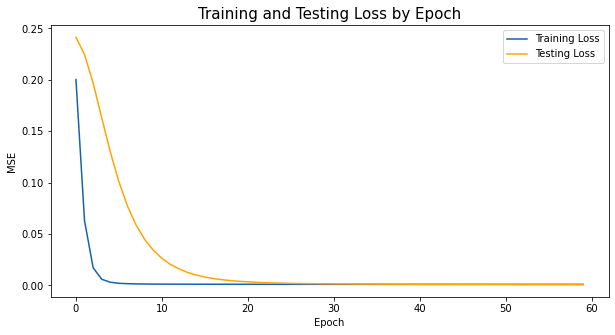

In [32]:
plt.figure(figsize=(10, 5))

plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 15)
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('MSE', fontsize = 10)
plt.legend(fontsize = 10);


In [33]:
embedding = Model(auto_encode.inputs, auto_encode.get_layer('bottleneck').output)
auto_encode_embedding = embedding.predict(tfidf_matrix_array)

In [34]:
recommend_coffee_from_description_ae(query, auto_encode_embedding)

Query: plum, berry, caturra, washed


,Name,Description,Process,Variety,similarity_score
16,Congo Kivu Kalehe Cooperative,"Sweet, spiced and with tangy citrus accents, flavor notes of orange, cardamom pod and clove, marmalade spread, and the acidic impression is grabby like grapefruit. City to Full City.",Wet Washed,Bourbon,0.970039
46,Ethiopia Organic Nensebo Refisa,"An aromatic cup in all of our roasts, dried florals, sweet herbs, and fragrant woody incense, notes of simple syrup, orange essence, fruit gum, and grabby citrus finish. City to Full City.",Wet Washed,Heirloom,0.958886
305,Colombia Caicedo Las Alegrias,"A cup with intimations of dried fruit against a backdrop of rustic, unrefined sugar sweetness, hints of dried raisin and plum, tea-like tannic acidity. Chocolatey dark roast. City to Full City+.",Wet Washed,"Caturra, Typica, Modern Hybrids",0.958379
57,Kenya Embu Gakui Peaberry,"Gakui's flavor profile is enlivened with fruit and spice notes like dried plum, date pieces, cinnamon stick, all spice powder, plum tea, tea-like tannic acidity, and some grapefruit bittering that...",Wet Washed,Bourbon,0.957957
325,Colombia Urrao Fray Moreno,"This coffee is anything but 'neutral'! Berry-toned aroma, stone fruit accent of red plum, hints of mint and Yerba Mate, and a tangy-sweet pomegranate note that heightens acidic impression. City to...",Wet Washed,Heirloom,0.957529


# Word2Vec

Word2Vec is a popular word embedding technique used to learn the semantics of the words in a corpus. Like an auto-encoder, it encodes each word in a vector. However, instead of training the input words through the reconstruction process (encode/decode), Word2Vec trains words against those that are near to them in the vector space. It achieves this in two ways: continuous bag of words (CBOW) or skip-gram. I have chosen the latter for this project because it tends to perform better on smaller datasets and represents rare words well [Source](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa).

However, one key downside to note about Word2Vec is that it cannot produce vectors for words that were not in the original dataset used for training. While there are more advanced methods to deal with unseen data (such as Facebook's FastText which builds vectors from root words), I have decided to simply exclude any unseen words if they occur in the query sentence.

For this project, I have chosen to train the model using Gensim's implementation of Word2Vec. These are the parameters I have adjusted for the model:
- min_count = 0 (low since we are using a small dataset)
- window = 2 (number of neighbouring words to affect the vector calculations)
- vector_size = 100
- alpha = 0.01 (learning rate)
- min_alpha = 0.0007 (min value at which learning rate will decrease linearly)
- sg = 1 (skip gram selected)


In [35]:
def is_word_in_model(word, model):
    """Check if word is in the corpus from the trained model"""
    assert type(model).__name__ == 'KeyedVectors'
    is_in_vocab = word in model.key_to_index.keys()
    return is_in_vocab

In [36]:
def recommend_coffee_from_description_w2v(query, dataset, model):
    query = clean_text(query)
    query = query.split(', ')
    in_vocab_list = []
    for w in query:
        #Remove unseen words from query sentence
        if is_word_in_model(w, model.wv):
            in_vocab_list.append(w)

    #Find similarity between query and dataset
    if len(in_vocab_list) == 0:
        print('Insufficient # of words in input')
    else:
        print(f'Query: {in_vocab_list}')
        similarity_matrix = np.zeros(len(dataset))  
        for i, data_sentence in enumerate(dataset):
            if data_sentence:
                similar_sentence = model.wv.n_similarity(
                        in_vocab_list, data_sentence)
            else:
                similar_sentence = 0
            similarity_matrix[i] = np.array(similar_sentence)
    
    similar_matrix = pd.DataFrame(similarity_matrix)
    similar_items = pd.DataFrame(similar_matrix)
    similar_items.columns = ["similarity_score"]
    similar_items = similar_items.sort_values('similarity_score', ascending=False)
    similar_items.reset_index(inplace=True)

    #Use index as an 'item_id' 
    similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
    similar_coffees = pd.DataFrame(similar_items.to_dict())
    similar_coffees.set_index('item_id', inplace=True)

    #List top recommendations 
    similar_df = pd.merge(df_sweetmarias, similar_coffees, left_index=True, right_index=True)
    similar_df.sort_values('similarity_score', ascending=False, inplace=True)
    return similar_df[['Name','Description','Process','Variety','similarity_score']].head(5)

In [37]:
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [38]:
w2v_model = Word2Vec(min_count=0,
                     window=2,
                     vector_size=100, 
                     alpha=0.01, 
                     min_alpha=0.0007, 
                     sg = 1) 

w2v_model.build_vocab(df_sweetmarias['tok_lem_combined'].values)
w2v_model.train(df_sweetmarias['tok_lem_combined'].values, total_examples=w2v_model.corpus_count, epochs=100, callbacks=[callback()],
                         compute_loss=True)

Loss after epoch 0: 69554.5
Loss after epoch 1: 69525.03125
Loss after epoch 2: 70263.640625
Loss after epoch 3: 68208.421875
Loss after epoch 4: 63497.6875
Loss after epoch 5: 60539.875
Loss after epoch 6: 56175.46875
Loss after epoch 7: 53887.375
Loss after epoch 8: 52866.625
Loss after epoch 9: 51546.1875
Loss after epoch 10: 50498.875
Loss after epoch 11: 49089.625
Loss after epoch 12: 49216.875
Loss after epoch 13: 48179.8125
Loss after epoch 14: 47111.375
Loss after epoch 15: 47220.1875
Loss after epoch 16: 46013.8125
Loss after epoch 17: 44839.9375
Loss after epoch 18: 44933.0625
Loss after epoch 19: 44528.625
Loss after epoch 20: 44349.75
Loss after epoch 21: 44190.75
Loss after epoch 22: 44112.875
Loss after epoch 23: 43729.625
Loss after epoch 24: 43426.25
Loss after epoch 25: 43449.5
Loss after epoch 26: 44499.125
Loss after epoch 27: 43551.375
Loss after epoch 28: 42950.0
Loss after epoch 29: 43211.0
Loss after epoch 30: 42683.125
Loss after epoch 31: 42996.375
Loss after e

(595740, 938800)

In [39]:
w2v_model.save(r'../saved_models/word2vec.model')

In [40]:
recommend_coffee_from_description_w2v(query, df_sweetmarias['tok_lem_combined'].values, w2v_model)

Query: ['plum', 'berry', 'caturra', 'washed']


,Name,Description,Process,Variety,similarity_score
314,Colombia Inzá Rio Paez,"The fruited side of Rio Paez emerges as it cools, hints of cherry, cooked apple and a winey plum note. Pour overs are profusely sweet, with a tea-like aftertaste and tannic bittering in mouthfeel....",Wet Washed,"Caturra, Typica, Modern Hybrids",0.937422
183,Guatemala Patzun Finca Las Camelias,"Fruit flavors are most front-facing at Full City, blackberry and red raisin rolled into dense layers of dark chocolate, and Dutch drinking cocoa, accents of torched sugar glaze. Full City to Full ...",Wet Washed,"Caturra, Bourbon, Modern Hybrids",0.931425
303,Colombia Buesaco Alianza Granjeros,"A caramel-sweet overtone, aromatic butterscotch note, hints of apple, dried date and an herbal accent in the aftertaste. Acidic impression like brisk black tea when roasted light. City to Full Cit...",Wet Washed,"Caturra, Bourbon, Typica, Modern Hybrids",0.929653
340,Peru Nuevo Trujillo Marcial Olivera,"One of our brighter Peru's, City roasts produce a bright acidic impression, fruit hints of black currant and red apple, opaque date sugar sweetness and hints of tree nut. City to Full City+. Good ...",Wet Washed,"Caturra, Bourbon, Typica, Modern Hybrids",0.929286
190,Guatemala Xinabajul Evelio Villatoro,"Complex as it cools, underlying flavors are fruited with caramelized sugars, accents of brisk tea, cardamom, and a berry note that feeds into a blueberry-like acidic impression. Delicious! City to...",Wet Washed,"Caturra, Bourbon, Typica, Modern Hybrids",0.928712


# BERT

BERT is a langugage model that represents one of the most recent advances in NLP. It is a bi-directional transformer pre-trained useing both masked language modelling (MLM) and next sentence prediction (NSL) on a large corpus comprising of BookCorpus and Wikipedia. Compared to Word2Vec, what makes transformers such as BERT more powerful is the ability to encode context of a given word from preceding and succeeding words in the vector via its *attention mechanism*. This attention mechanism allows us to look at the totality of the a sentence and make connections between words and its relevant context - this is markedly different from and more complext than the simple feed-forward auto-encoder which I have built above as that treats each word as an input independent of each other. 

For this project, I have chosen to use a direct implementation of the BERT architecture from SentenceTransformers. More specifically, I have selected the *paraphrase-MiniLM-L6-v2* model from SentenceTransformers as it performs relatively fast and is pre-trained specifically for tasks such as clustering or semantic search (more details [here](https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2)). 

In [41]:
def recommend_coffee_from_description_bert(query, corpus_embeddings):
    
    set_seed(42)
    
    #Embed query
    clean_query = clean_text(query)
    query_embedding = BERT_model.encode(query, convert_to_tensor=True)
    
    print(f'Query: {clean_query}')
    
    #Matrix of similarity between query and database
    cos_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
    similarity_matrix = pd.DataFrame(cos_scores)
    
    #New column of 'similarity_score'
    similar_items = pd.DataFrame(similarity_matrix)
    similar_items.columns = ["similarity_score"]
    similar_items = similar_items.sort_values('similarity_score', ascending=False)
    similar_items.reset_index(inplace=True)
    
    #Use index as an 'item_id' 
    similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
    similar_coffees = pd.DataFrame(similar_items.to_dict())
    similar_coffees.set_index('item_id', inplace=True)
    
    #List top recommendations 
    similar_df = pd.merge(df_sweetmarias, similar_coffees, left_index=True, right_index=True)
    similar_df.sort_values('similarity_score', ascending=False, inplace=True)
    return similar_df[['Name','Description','Process','Variety','similarity_score']].head(5)

In [42]:
set_seed(42)
BERT_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
corpus_embeddings = BERT_model.encode(df_sweetmarias['cleaned_combined'].values, convert_to_tensor=True)

In [43]:
recommend_coffee_from_description_bert(query, corpus_embeddings)

Query: plum, berry, caturra, washed


,Name,Description,Process,Variety,similarity_score
314,Colombia Inzá Rio Paez,"The fruited side of Rio Paez emerges as it cools, hints of cherry, cooked apple and a winey plum note. Pour overs are profusely sweet, with a tea-like aftertaste and tannic bittering in mouthfeel....",Wet Washed,"Caturra, Typica, Modern Hybrids",0.602068
325,Colombia Urrao Fray Moreno,"This coffee is anything but 'neutral'! Berry-toned aroma, stone fruit accent of red plum, hints of mint and Yerba Mate, and a tangy-sweet pomegranate note that heightens acidic impression. City to...",Wet Washed,Heirloom,0.578095
47,Ethiopia Organic Shakiso Kayon Mountain Farm,"Unrefined sugar sweetness is cut through by a rindy citrus flavor, fruited accent notes of orange and dried strawberry, aromatic herbals, Earl Grey and hibiscus teas, and a soft floral jasmine not...",Wet Washed,Heirloom,0.574332
39,Ethiopia Guji Hambela Dabaye,"Impressive sweetness, demurara sugar, cream soda, mild fruited accents of nectarine and lemon, and a touch of clove in aroma. Peach-like acidity helps build out the fruited impressions. City to Fu...",Wet Washed,Heirloom,0.568525
92,Kenya Nyeri Kamoini Peaberry,"Bodied, a plump blackberry note, fruits cooked with brown sugar like pineapple upside down cake, accents of clove and nutmeg, and blueberry acidic impression. City to Full City. Good for espresso.",Wet Washed,Bourbon,0.565445


# Model Comparison with OCR Input

I will now compare the 4 models with an input from the OCR tool. Results are analysed in detail below.

Overall, I would think that the TF-IDF model satisifes the main aims of the recommender system purely because the input from the OCR tool are single words. Instead of typical search query that has semantic meaning (e.g. 'I am looking for a washed processed Tanzanian coffee with notes of molasses and friar plums'), the OCR tool has distilled the query into keywords with little or not semantic structure. As such, TF-IDF actually produced good results, even though it is considered less complex than the state-of-the-art BERT model.

However, in future developments, an advanced model is probably more fit for purpose. For example, recognising the difference between 'honey taste' and 'honey processing method' will probably need a BERT model to analyse context. The three other models in this project do not have that ability to make such contextual references since they are uni-directional (BERT is a bi-directional transformer). 

In [44]:
ocr = pd.read_csv(r'../data/consolidated_all_images_70pct_0811_vfinal.csv')

In [45]:
query = ocr['final_text'][9]
query

'even, not, coffee, roaster, washed, tanzania, molasses, plum, friar'

**TF-IDF**

Decent results: both 'molasses' and 'plum'  appear in the top 4 recommendations.

In [46]:
recommend_coffee_from_description_tfidf(query, tfidf_matrix_array)

Query: washed, tanzania, molasses, plum, friar


,Name,Description,Process,Variety,similarity_score
323,Colombia Tolima Productores de Ibagué,"Unrefined sugar sweetness is central to the cup, accented by top notes of oatmeal cookie, molasses, dried date and cola nut, with plum-like acidity. City+ to Full City+.",Wet Washed,"Caturra, Bourbon, Modern Hybrids",0.329559
309,Colombia Ibagué Rio Combeima,"Delicious in the light to middle roasts, panela and molasses sweetness, winey apple and plum hints, a cinnamon note, tannic black tea and cranberry-like acidic impression. City to City+.",Wet Washed,"Caturra, Bourbon, Typica, Modern Hybrids",0.309904
105,Rwanda Dry Process Nyakabingo,"Middle roasts move beyond molasses sweetness, to fruit and spice flavors, notes of berry-infused dark chocolate, plum, overripe citrus, and a hint of heart of palm in the finish. City+ to Full City.",Dry Natural,Bourbon,0.298306
328,Colombia Urrao Valle de Penderisco,"Molasses, demurara sugar, moderate brightness, accents of berry and hibiscus flower tea. Dark roasts boast heavy-handed cocoa roast flavors and plum. City+ to Full City+. Good for espresso.",Wet Washed,"Caturra, Bourbon, Heirloom",0.290191
305,Colombia Caicedo Las Alegrias,"A cup with intimations of dried fruit against a backdrop of rustic, unrefined sugar sweetness, hints of dried raisin and plum, tea-like tannic acidity. Chocolatey dark roast. City to Full City+.",Wet Washed,"Caturra, Typica, Modern Hybrids",0.196123


**Auto-Encoder**

Results from our auto-encoder are fair - it maanged to pick up a few coffees with 'plum' key words, but nothing on 'molasses'.

In [47]:
recommend_coffee_from_description_ae(query, auto_encode_embedding)

Query: washed, tanzania, molasses, plum, friar


,Name,Description,Process,Variety,similarity_score
57,Kenya Embu Gakui Peaberry,"Gakui's flavor profile is enlivened with fruit and spice notes like dried plum, date pieces, cinnamon stick, all spice powder, plum tea, tea-like tannic acidity, and some grapefruit bittering that...",Wet Washed,Bourbon,0.956376
305,Colombia Caicedo Las Alegrias,"A cup with intimations of dried fruit against a backdrop of rustic, unrefined sugar sweetness, hints of dried raisin and plum, tea-like tannic acidity. Chocolatey dark roast. City to Full City+.",Wet Washed,"Caturra, Typica, Modern Hybrids",0.952937
110,Rwanda Nyamasheke Gatare Peaberry,"Aspects of semi-refined sugars, fruited acidity, laced with hints of warming spice, orange tea, and dried apple. Deep chocolate roast flavors with darker roast develoment. City to Full City+. Good...",Wet Washed,Bourbon,0.950206
175,Guatemala Huehuetenango Finca Rosma,"A flavor compound of oatmeal-raisin cookie, molasses sugar, rustic dark fruit, cacao bittersweetness, dried coconut, and berry-like acidity. City+ to Full City+. Good for espresso.",Wet Washed,"Caturra, Bourbon, Typica, Modern Hybrids",0.949646
76,Kenya Muranga Kangunu Peaberry,"Sweet at its core, Kangunu peaberry offers an array of fruited accent notes, such as plump cranberry, holiday fruit punch, bergamot citrus, tangy plum tea and tamarind. Finish is so aromatic. City...",Wet Washed,Bourbon,0.949599


**Word2Vec**

For Word2Vec, we only have 3 query keywords. The words 'Tanzania' and 'friar' have been dropped because they are not in the vocabulary of the corpus that we trained on - this is one of the key advantage of Word2Vec which was mentioned earlier.

In [48]:
recommend_coffee_from_description_w2v(query, df_sweetmarias['tok_lem_combined'].values, w2v_model)

Query: ['washed', 'molasses', 'plum']


,Name,Description,Process,Variety,similarity_score
57,Kenya Embu Gakui Peaberry,"Gakui's flavor profile is enlivened with fruit and spice notes like dried plum, date pieces, cinnamon stick, all spice powder, plum tea, tea-like tannic acidity, and some grapefruit bittering that...",Wet Washed,Bourbon,0.940001
305,Colombia Caicedo Las Alegrias,"A cup with intimations of dried fruit against a backdrop of rustic, unrefined sugar sweetness, hints of dried raisin and plum, tea-like tannic acidity. Chocolatey dark roast. City to Full City+.",Wet Washed,"Caturra, Typica, Modern Hybrids",0.928197
95,Kenya Nyeri Kiruga AB,"Depth of sweetness (scoring 9.5!), raw sugars, fruit jam hints, fig, dried berry and a spiced grape juice note as it cools. Moderate brightness and capable of berry-laden cocoa when roasted dark. ...",Wet Washed,Bourbon,0.927735
65,Kenya Kiambu Fram Farm Peaberry,"Fruit and brown sugar sweetness are intense, accents of grape, fresh date, fig, blackberry crumble, a woody incense aromatic note, and well-integrated, berry-like acidity. City+ to Full City.",Wet Washed,Bourbon,0.926772
120,Tanzania Nogorongoro Karatu Peaberry,"A tasty confluence of moderate fruit and sweetness, and relatively high acidity lends structure to notes of palm sugar, berry tea, ripe black plum, a lemongrass note, and tannic bittering in the b...",Wet Washed,"Bourbon, Modern Hybrids",0.925983


**BERT**

Bert, which was trained on Wikipedia and BookCorpus, have associated Tanzania as a country and selected coffees with country names appearing in the description (e.g. Kenya, Guatemala, Burundi). In addition, it was also able to associate 'molasses' with 'sweetness' ('molasses sweetness' appear 4 times in the corpus), and have generated coffee descriptions with 'sweetness' in them. However, it is important to note that the key words such as 'molasses' and 'plum' do not show up in most of the top 5 recommendations.

When the word 'Tanzania' is removed, results are a lot better as the country 'Tazania' was probably unduly affecting the BERT results by recommending coffees whose descriptions have a country word in them.

*With 'Tanzania'*  

In [49]:
recommend_coffee_from_description_bert(query, corpus_embeddings)

Query: washed, tanzania, molasses, plum, friar


,Name,Description,Process,Variety,similarity_score
0,Burundi Commune Mutambu,"Such a versatile Burundi, a neutral sweetness is accented by complex baking spices, creamed honey, loose leaf black tea and bittering cocoa when roasted dark. City to Full City+. Good for espresso.",Wet Washed,Bourbon,0.712786
186,Guatemala Proyecto Xinabajul Donaldo Villatoro,"An aromatic Guatemalan coffee with brisk acidity, toasted sugar sweetness, and flavor notes of warming spices, Earl Grey tea, dried plum and milk chocolate. City to Full City.",Wet Washed,"Caturra, Bourbon, Typica",0.696692
328,Colombia Urrao Valle de Penderisco,"Molasses, demurara sugar, moderate brightness, accents of berry and hibiscus flower tea. Dark roasts boast heavy-handed cocoa roast flavors and plum. City+ to Full City+. Good for espresso.",Wet Washed,"Caturra, Bourbon, Heirloom",0.693887
15,Cameroon Caplami Java Cultivar,"An interesting, thick bodied cup, notes of caramel and molasses, cinnamon, pipe tobacco, powdered orange drink, malted grains, aromatic woody dimension. City++ to Full City+.",Wet Washed,Heirloom,0.690076
150,El Salvador Matalapa Mirador,"Middle roasts are bodied, notes of hazelnut spread, milk chocolate, honey on toast, fruited cacao, Brazil nut, finishing with some tea tannins in mouthfeel. City+ to Full City+. Good for espresso.",Wet Washed,Bourbon,0.687154


*Without 'Tanzania'*  

In [50]:
query_revised = 'washed, molasses, plum, friar'

In [51]:
recommend_coffee_from_description_bert(query_revised, corpus_embeddings)

Query: washed, molasses, plum, friar


,Name,Description,Process,Variety,similarity_score
328,Colombia Urrao Valle de Penderisco,"Molasses, demurara sugar, moderate brightness, accents of berry and hibiscus flower tea. Dark roasts boast heavy-handed cocoa roast flavors and plum. City+ to Full City+. Good for espresso.",Wet Washed,"Caturra, Bourbon, Heirloom",0.557297
15,Cameroon Caplami Java Cultivar,"An interesting, thick bodied cup, notes of caramel and molasses, cinnamon, pipe tobacco, powdered orange drink, malted grains, aromatic woody dimension. City++ to Full City+.",Wet Washed,Heirloom,0.548952
12,Burundi Rwiri Yagikawa,"A medium-bodied coffee with silky mouthfeel, turbinado sweetness, opening up to hints of chamomile and roasted barley teas, clove powder, and a subtle whiff of orange in the nose. City to Full City.",Wet Washed,Bourbon,0.542813
207,Mexico Chiapas Cerro Brujo Don Sergio,"A 'complete' cup with regard to developed sweetness and subtle top notes, brown sugar flavors, molasses aroma, subtle hint of orange and dried fruit that don't detract from core sweetness. City+ t...",Wet Washed,,0.511689
49,Ethiopia Sidama Shentabene Chire,"This Sidama makes for a delicate, refined pour over, perfumed pearl jasmine and rose water aroma, simple syrup sweetness, and hints of red apple, Botan rice candies, and black tea. City to City+.",Wet Washed,Heirloom,0.511194


# Acknowledgements

These are the resources which I have found helpful:


[BERT (HuggingFace/SentenceTransformers)](https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2)
<br>
[Gensim's Word2Vec Implementation](https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/)
<br>
[Building Recommender Systems](https://medium.com/analytics-vidhya/movie-recommender-system-using-content-based-and-collaborative-filtering-84a98b9bd98e)
<br>
[Building Recommender Systems](https://towardsdatascience.com/build-a-text-recommendation-system-with-python-e8b95d9f251c)
<br>

Other Reading Materials:
<br>
https://www.jeremyjordan.me/autoencoders/
<br>
https://neptune.ai/blog/bert-and-the-transformer-architecture-reshaping-the-ai-landscape

